In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Statistics
using LsqFit
using Distributions
using LaTeXStrings
using JLD2

import Stripeline as Sl
import Pandas as Pd

In [2]:
function run_scaling(
    tel_angles,
    sky_model::String,
    nside::Int,
    setup::PRMaps.Setup
)
    
    strip = Pd.query(Pd.read_pickle("../instruments/lspe_strip_instrument.pkl"), :(frequency==43.0))
    signal = get_foreground_maps(strip, sky_model, nside)[1]

    camera = Sl.CameraAngles()
    ideal, _ = makeIdealMapIQU(camera, signal, setup)
    obs_ideal = HealpixMap{Float64, RingOrder}(ideal.i.resolution.nside)
    polDegreeMap!(obs_ideal, ideal.q, ideal.u)        

    maps_pol = HealpixMap[]

    for i in tel_angles
        m, _ = makeErroredMapIQU(camera, i, signal, setup)
        buffer = HealpixMap{Float64, RingOrder}(m.i.resolution.nside)
        polDegreeMap!(buffer, m.q, m.u)        
        push!(maps_pol, buffer)
    end

    error = [ (obs_ideal - errored) for errored in maps_pol]

    error_hist = [ i[isfinite.(i)] for i in error]

    distro_fit = [ fit(Cauchy, data) for data in error_hist ]

    sigma = [ scale(distro) for distro in distro_fit ]

    return sigma

end

run_scaling (generic function with 1 method)

In [3]:
nside = 512
sky_model = "s0"
obs_days = 5
 
setup = PRMaps.Setup(
    sampling_freq_Hz = 50.,
    total_time_s = 24. * 3600. * obs_days
    )
nothing

fit_params = []

Any[]

In [4]:
errored_angles_deg = [0.25/60, 0.5/60, 1.0/60, 5.0/60]
omega_wobble_deg = [0.0, 90.0, 180.0, 270.0]

errored_angles_arcsec = [15, 30, 60, 300]

xdata = log10.(range(minimum(errored_angles_arcsec), stop=maximum(errored_angles_arcsec), length=10000))

nothing

In [5]:
tel_angs_altitude = [Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_ground = [Sl.TelescopeAngles(wheel3ang_0_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_fork = [Sl.TelescopeAngles(forkang_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_0 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(0.0)) for i in errored_angles_deg]
tel_angs_90 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(90.0)) for i in errored_angles_deg]
tel_angs_180 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(180.0)) for i in errored_angles_deg]
tel_angs_270 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(270.0)) for i in errored_angles_deg]
nothing

In [6]:
rerun_simulation = false
log_scale = true

true

In [7]:
if rerun_simulation
    # THETA 0
    result_altitude = run_scaling(tel_angs_altitude, sky_model, nside, setup) * 2 
    save_object("../results/scaling/altitude.jld2", result_altitude)

    # PHI 0
    result_ground = run_scaling(tel_angs_ground, sky_model, nside, setup) * 2
    save_object("../results/scaling/ground.jld2", result_ground)

    # FORK
    result_fork = run_scaling(tel_angs_fork, sky_model, nside, setup) * 2
    save_object("../results/scaling/fork.jld2", result_fork)

    # WOBBLE
    result_0 = run_scaling(tel_angs_0, sky_model, nside, setup) * 2
    result_90 = run_scaling(tel_angs_90, sky_model, nside, setup) * 2
    result_180 = run_scaling(tel_angs_180, sky_model, nside, setup) * 2
    result_270 = run_scaling(tel_angs_270, sky_model, nside, setup) * 2

    save_object("../results/scaling/wobble_0.jld2", result_0)
    save_object("../results/scaling/wobble_90.jld2", result_90)
    save_object("../results/scaling/wobble_180.jld2", result_180)
    save_object("../results/scaling/wobble_270.jld2", result_270)
else
    result_altitude = load_object("../results/scaling/altitude.jld2")
    result_ground = load_object("../results/scaling/ground.jld2")
    result_fork = load_object("../results/scaling/fork.jld2")
    result_0 = load_object("../results/scaling/wobble_0.jld2")
    result_90 = load_object("../results/scaling/wobble_90.jld2")
    result_180 = load_object("../results/scaling/wobble_180.jld2")
    result_270 = load_object("../results/scaling/wobble_270.jld2") 
end

results = [result_altitude, result_ground, result_fork, result_0, result_90, result_180, result_270]
if log_scale
    results = [log10.(i) for i in results]
    angles = [log10.(i) for i in errored_angles_arcsec]
end
nothing

# Model used to fit

The error is fitted using:

$\log\epsilon = p_1 \log^2 x + p_2 \log x + p_3$

where x is the bias in the configuration angles

In [8]:
# @. model_linear(x,p) =  p[1]*x^2 + p[2]*x + p[3]
@. model_linear(x,p) =  p[2]*x + p[3]

model_linear (generic function with 1 method)

In [9]:
fit_results = [curve_fit(model_linear, angles, results[i], [0.0, 0.5, 1.0]).param for i in range(1,length(results))]
fit_curves = [model_linear(xdata, i) for i in fit_results]
nothing

In [10]:
fit_results

7-element Vector{Vector{Float64}}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913058872, -3.224556209225022]
 [0.0, 0.9921424103321829, -3.1716109290203622]
 [0.0, 0.9978102237713562, -3.224572028462835]
 [0.0, 0.9927037650119024, -3.172767180468137]

# Plot

In [11]:
markers = [:rect :utriangle :star :circle :circle :circle :circle]
my_palette = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#99DDFF", "#44BB99", "#BBCC33"]

xlabel = L"\textrm{Configuration \ angle \ bias} \ [\log_{10}(\textrm{arcsec})]"
ylabel = L"\textrm{F.W.H.M.} \ [\log_{10}(\mu K)]"

labels = [L"\vartheta_0" L"\varphi_0" L"\hat{t}_\textrm{fork}" L"\hat{z}_\textrm{VAX},ω_\textrm{VAX}: 0°" L"\hat{z}_\textrm{VAX},ω_\textrm{VAX} : 90°" L"\hat{z}_\textrm{VAX},ω_\textrm{VAX} : 180°" L"\hat{z}_\textrm{VAX},ω_\textrm{VAX} : 270°"]

nothing

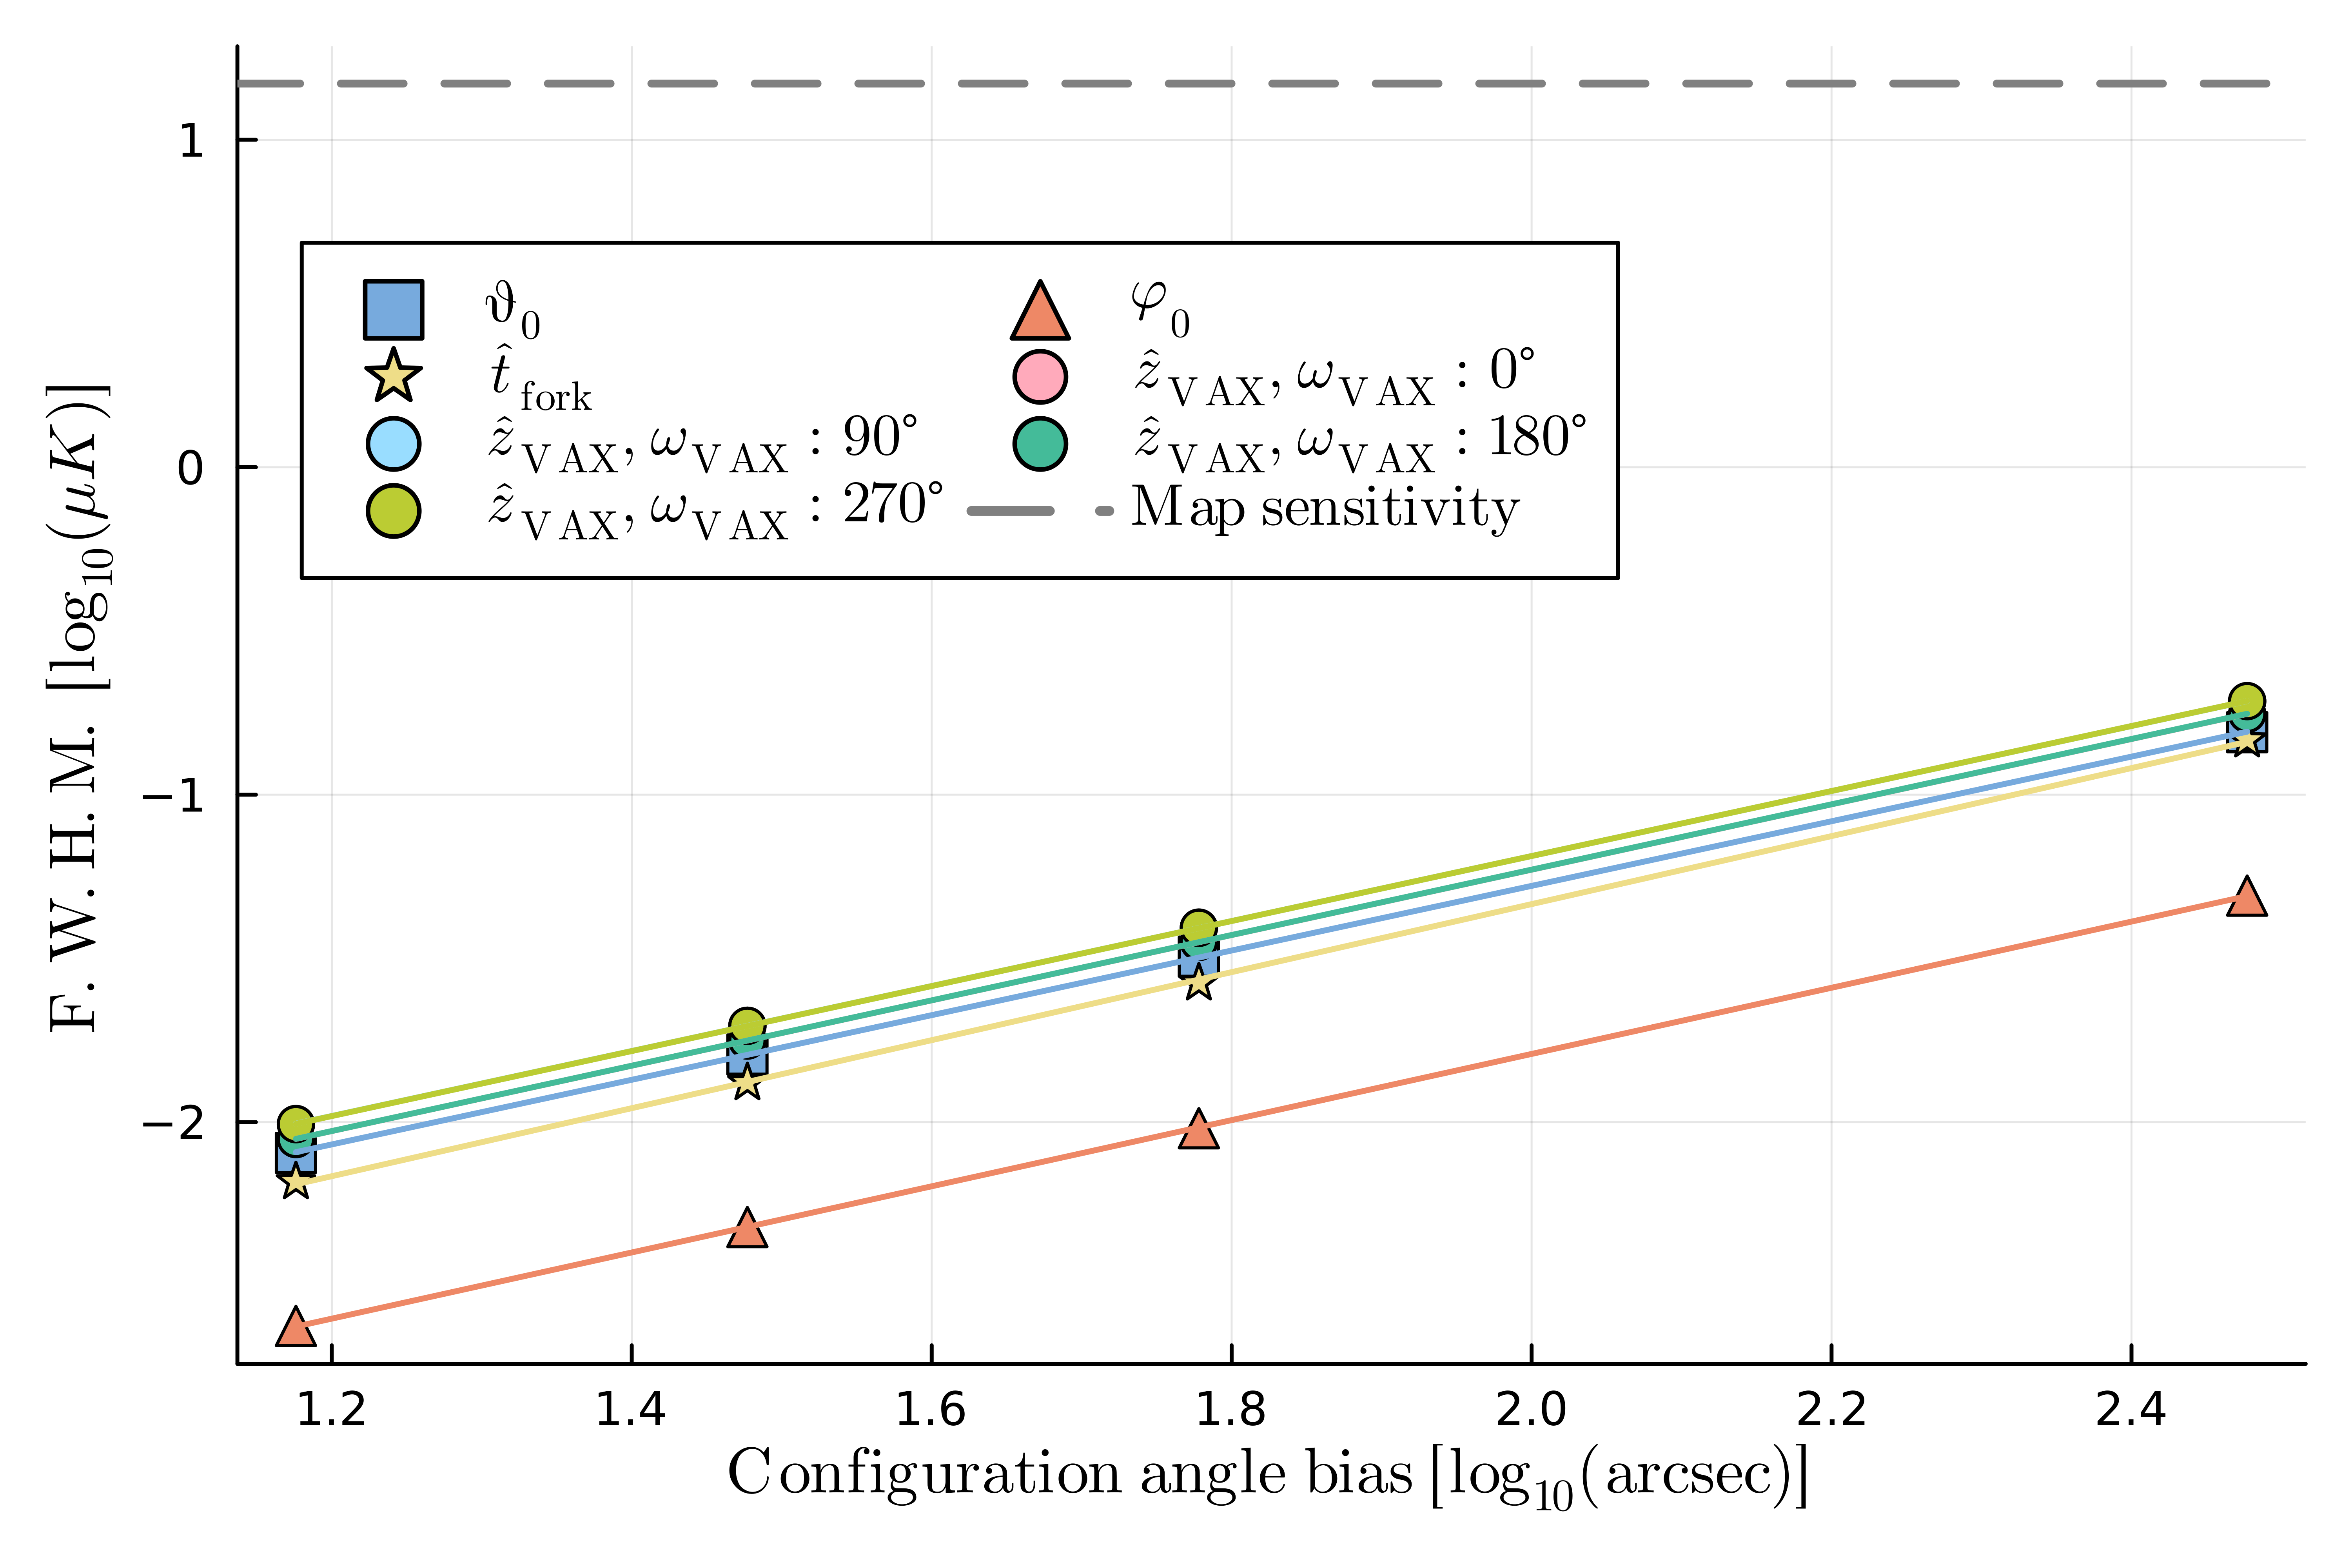

In [37]:
fig = scatter(
    angles, results, 
    markershape = markers, markersize = 5, palette = my_palette, 
    xlabel=xlabel, ylabel=ylabel, 
    labels = labels, 
    legendfontsize = 10, 
    legend=(0.12,0.8), 
    legendcolumns = 2, 
    size = (600,400), dpi = 1000,
    leftmargin=3Plots.mm,
    bottommargin=3Plots.mm
)

fig = plot!(
    xdata, fit_curves,
    linecolor = :match,
    linewidth = 1.5,
    labels = nothing
)

# Noise level associated to the instrument sensitivity at 43GHz for a 512 nside map
noise = 102 / (nside2resol(512) * (60 * 180) / π)
fig = hline!([log10(noise)], label = L"\textrm{Map \ sensitivity}", style=:dash, linewidth=2.0, color=:grey)

savefig("../results/scaling/scaling.pdf")
display(fig)